# Modelos de neurônios de disparo

In [1]:
import numpy as np # processamento matemático
import matplotlib.pyplot as plt # criação de gráficos
from scipy.integrate import solve_ivp # solucionar eq. dif.

## Modelos
Os modelos abaixo simulam o disparo de potenciais de ação, o mecanismo usado pelos neurônios para transmissão de informação. [[1](#1-Claren-Tan,-Markp-Sarlika-&-Nikola-Kasabov,-%22Spiking-Neural-Networks:-Background,-Recent-Development-and-the-NeuCube-Architecture%22,-Neural-Processing-Letters-(2020)-52:1675-1701)]

|Modelos | N. de variáveis | Complexidade | Biologicamente plausível|
--- | --- | --- | ---
|Leaky integrate-and-fire|1|Muito baixa|Não|
|Izhikevich|2|Muito baixa|Não|
|SRM|1|Baixa|Não|
|Hodgkin-Huxley|4|Muito alta|Sim|
|FitzHugh-Nagumo|2|Média|Não|
|Wilson|2|Média|Não|
|Moris-Lecar|3|Alta|Sim|

### Leaky integrate-and-fire

O modelo Leaky integrate-and-fire (LIF) é composto por apenas uma equação diferencial, que representa o comportamento do circuito abaixo:
![teste](imagens/circuito_lif.svg)

No circuito, a capacitância $C_m$ representa a capaciância da membrana bilipídica do neurônio. O potencial de membrana $V_m$ se altera com a entrada/saída de íons através de canais existentes ao longo da membrana do neurônio, bem como com a aplicação de uma corrente $I_{ap}$. Nesse modelo, apenas o canal de vazamento (_leak_) é representado, através do potencial de vazamento $E_L$ e a condutância de vazamento $G_L$ (o inverso da resistência). A dinâmica de alteração do potencial de membrana é dada pela seguinte equação:

$
c_m\frac{dV_m}{dt} = G_L(E_L-V_m)+I_{ap}; \text{se } V_m > V_{th} \text{ então } V_m\mapsto V_{reset}
$

A parte direita da equação é uma condição em que se o potencial de membrana ultrapassar um determinado limiar $V_{th}$, caracterizando o disparo (_fire_) de um potencial de ação, então o valor do potencial é atualizado para um valor de _reset_ $V_{reset}$. [[2](#2-Paul-Miller,-%22An-introductory-course-in-computational-neuroscience%22,-The-MIT-Press,-2018)]

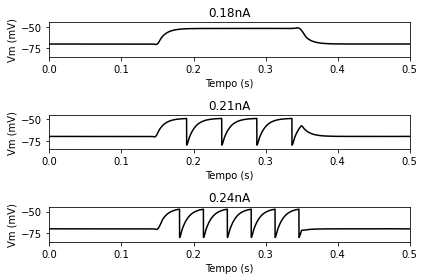

In [2]:
def lif(t, v, gl, el, cm, iap, vth, vr):
    # no intervalo de 0.15 até 0.35 a corrente é aplicada
    if t > 0.15 and t < 0.35:
        i = iap
    else: # no resto do tempo a corrente é 0
        i = 0
    dvdt = (gl*(el-v) + i)/cm # calcula a equação diferencial
    # [-1] indica o último elemento do vetor
    # nesse caso, significa o último potencial calculado
    if v[-1] > vth: # se o potencial ultrapasssar o limiar
        v[-1] = vr  # muda o potencial para o valor de reset
    return dvdt

# parametros de simulação
t0 = 0 # tempo inicial
tf = 0.5 # tempo final
dt = 0.0001 # passo de tempo
tvec = np.arange(t0, tf, dt) # vetor de pontos no tempo

# parametros do neuronio lif
tau = 0.010 # constante de tempo da membrana
el = -0.070 # potencial de vazamento (ou potencial de repouso)
vth = -0.050 # potencial de limiar
vr = -0.080 # potencial de reset
cm = 100*10**(-12) # capacitância de membrana total
gl = cm/tau # condutância de membrana total (condutância de vazamento)
v0 = el # o potência de membrana inicia no potencial de repouso

# simulacao de trials
iap = np.array([180, 210, 240])*(10**(-12)) # valores de corrente aplicados

ntrials = len(iap) # numero total de trials
_, ax = plt.subplots(ntrials) # cria conjunto de figuras
for trial in range(ntrials): # laço ao longo dos trials
    parametros = [gl, el, cm, iap[trial], vth, vr] # agrupa os parâmetros
    sol = solve_ivp(lif, [t0, tf], [v0], t_eval=tvec, args=parametros)

    ax[trial].plot(sol.t,sol.y[0]*1000, 'k') # plota o potencial vs tempo
    ax[trial].set_xlim(0, 0.5) # ajusta a escala em x
    ax[trial].set_ylim(1000*(vr-0.005), 1000*(vth+0.005)) # e em y
    ax[trial].set_xlabel('Tempo (s)') # nomeia o eixo x
    ax[trial].set_ylabel('Vm (mV)') # nomeia o eixo y da segunda linha
    ax[trial].set_title(f'{str(iap[trial]*10**9)}nA') # o título é a corrente
plt.tight_layout()
plt.show() # exibe a figura

### Izhikevich
O modelo de Izhikevich é um modelo de disparo que é considerado biologicamente plausível, como o de Hodgkin-Huxley, porém computacionalmente eficiente, como o LIF, pois usa apenas duas equações diferenciais, uma para a variável $v$, referente ao potencial de membrana do neurônio, e a outra para $u$, que refere-se à recuperação da membrana.

$
\frac{dv}{dt} = 0.04v^2+5v+140-u+i
\\
\frac{du}{dt} = a(bv-u)
\\
\text{se } v \geq 30mV\text{ então }
\begin{cases}
v\gets c\\
u\gets u + d
\end{cases}
$

As constantes $a, b, c\text{ e }d$ são sefinidos como segue:
- $a$ refere-se à escla de tempo da variável de recuperação. Quanto menor o valor mais lenta é a recuperação
- $b$ refere-se à sensibilidade da variável de recuperação às flutuações sublimiares do potencial de membrana. Valores maiores agrupam mais as variáveis $u$ e $v$, resultando em oscilações sublimiares e dinâmicas de disparo de baixo potencial
- $c$ refere-se ao valor de reset do potencial de membrana após o disparo
- $d$ refere-se ao valor de reset da variável de recuperação após o disparo

Valores padrão das constantes, que geram padrões de disparo conhecidos, estão incluídos no código comentadas individualmente (a linha descomentada é a que será executada). Detalhes de cada um dos padrões de disparo citados podem ser encontrados em [[3]](#3-Eugene-M.-Izhikevich,-%22Simple-Model-of-Spiking-Neurons%22,-IEEE-Transactions-on-Neural-Networks,-Vol,-14,-No.-6,-November-2003).

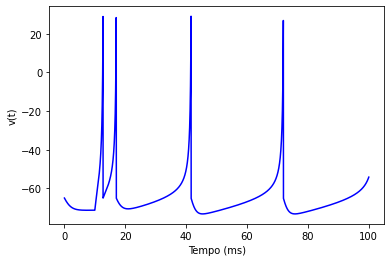

In [3]:
"""
Valores das constantes a, b, c, d

mantenha uma das linhas descomentadas para usar os valores listados
"""
const = [0.02, 0.2, -65, 8] # regular spiking
#const = [0.02, 0.2, -55, 4] # intrinsically bursting
#const = [0.02, 0.2, -50, 2] # chattering
#const = [0.1, 0.2, -65, 2] # fast spiking
#const = [0.02, 0.25, -65, 0.05] # thalamo-cortical
#const = [0.1, 0.26, -65, 2] # resonator
#const = [0.02, 0.25, -65, 2] # low-threshold spiking

# separa os valores das constantes para variáveis
a = const[0]
b = const[1]
c = const[2]
d = const[3]

# criação do vetor de tempo
t0 = 0
tf = 100
dt = 0.01
tvec = np.arange(t0, tf, dt)

v = (-65)*np.ones(len(tvec)) # inicializa o potencial de membrana
u = b*v # inicializa a variável de recuperação
I = np.zeros(len(tvec)) # inicializa a corrente aplicada
I[1000:] = 15 # muda o valor da corrente no intervalo especificado

# resolve as equações usando o método de euler
# solve_ivp não se aplica aqui por causa das condições
for i in range(1, len(tvec)):
    v[i] = v[i-1] + dt*(0.04*v[i-1]**2 + 5*v[i-1] + 140 - u[i-1] + I[i])
    u[i] = u[i-1] + dt*(a*(b*v[i-1]-u[i-1]))
    if v[i] > 30:
        v[i] = c
        u[i] = u[i] + d

# plota o potencial em função do tempo
plt.plot(tvec, v, 'b')
plt.xlabel('Tempo (ms)')
plt.ylabel('v(t)')
plt.show()

### Hodgkin-Huxley

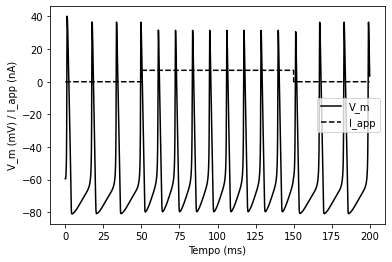

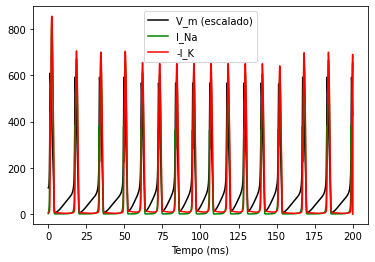

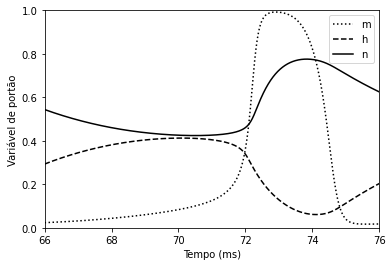

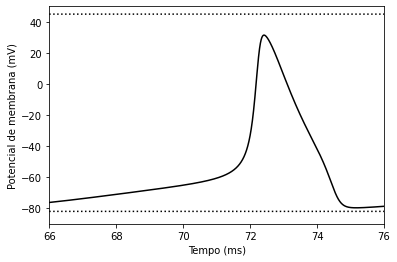

In [4]:
# parâmetros de simulação
dt = 0.0002 # passo de tempo
tmax = 200 # simula por 200ms
t = np.arange(0, tmax, dt) # vetor de pontos no tempo
istart = 50 # instante que inicia a aplicação de corrente
ilength = 100 # duração do pulso de corrente aplicada

# parâmetros do modelo HH
ibase = 0 # densidade de corrente base (nA/cm^2) fora do pulso
ie = 7 # densidade de corrente extra durante o pulso

e_l = -10.613 # potencial de reversão de vazamento (mV)
e_Na = -115 # potencial de reversão para canais de sódio
e_K = 12 # potencial de reversão para canais de potássio

g_l = 0.3 # condutância específica de vazamento (Mohm/cm^2)
g_Na = 120 # condutância específica de sódio
g_K = 36 # condutância específica de potássio

cm = 1 # capacitância específica de membrana (nF/cm^2)

# cria vetores para armazenar o resultado da integração numérica
v = np.zeros(len(t)) # vetor do potencial de membrana
n = np.zeros(len(t)) # n: variável de portão da ativação de potássio
m = np.zeros(len(t)) # m: variável de portão da ativação de sódio
h = np.zeros(len(t)) # h: variável de portão da inativação de sódio

# cria o vetor com a corrente aplicada
iapp = ibase*np.ones(len(t)) # vetor da corrente aplicada
# no intervalo determinado muda o valor da corrente (pulso)
iapp[round(istart/dt)+1:round((istart+ilength)/dt)] = ie

# condições iniciais
v[0] = e_l
n[0] = 0.35
m[0] = 0.05
h[0] = 0.75

# opcional, usar apenas caso queira plotar as correntes individuais
itotal = np.zeros(len(t)) # para plotar a corrente total
i_Na = np.zeros(len(t)) # para plotar a corrente de sódio
i_K = np.zeros(len(t)) # para plotar a corrente de potássio
i_L = np.zeros(len(t)) # para plotar a corrente de vazamento

for i in range(len(t)-1): # para ver como as coisas mudam no tempo
    i_L[i] = g_l*(e_l-v[i]) # calcula a corrente de vazamento
    vm = v[i] # para permitir a troca de unidades, se necessário

    # variáveis de portão de sódio e potássio são definidas pela taxa
    # de transição dependente de tensão entre estados, chamados alpha
    # e beta. As unidades são 1/ms
    # para cada variável existe um par alpha e beta
    if vm == -25:
        alpha_m = 0.1/0.1
    else:
        alpha_m = (0.1*(vm+25))/(np.exp(0.1*(vm+25))-1)
    beta_m = 4*np.exp(vm/18)
    alpha_h = 0.07*np.exp(vm/20)
    beta_h = 1/(1+np.exp((vm+30)/10))
    if vm == -10:
        alpha_n = 0.01/0.1
    else:
        alpha_n = (0.01*(vm+10))/(np.exp(0.1*(vm+10))-1)
    beta_n = 0.125*np.exp(vm/80)

    # a partir de alpha e beta encontramos os valores em regime
    # permanente e constantes de tempo para cada variável de portão
    tau_m = 1/(alpha_m+beta_m)
    m_inf = alpha_m/(alpha_m+beta_m)

    tau_h = 1/(alpha_h+beta_h)
    h_inf = alpha_h/(alpha_h+beta_h)

    tau_n = 1/(alpha_n+beta_n)
    n_inf = alpha_n/(alpha_n+beta_n)

    if i > 0: # atualiza as variáveis de portão
        m[i] = m[i-1] + (m_inf-m[i-1])*dt/tau_m # atualiza m

        h[i] = h[i-1] + (h_inf-h[i-1])*dt/tau_h # atualiza h

        n[i] = n[i-1] + (n_inf-n[i-1])*dt/tau_n # atualiza n

    i_Na[i] = g_Na*m[i]*m[i]*m[i]*h[i]*(e_Na-v[i]) # corrente de sódio

    i_K[i] = g_K*n[i]*n[i]*n[i]*n[i]*n[i]*(e_K-v[i]) # corrente de potássio

    itotal[i] = i_L[i]+i_Na[i]+i_K[i]-iapp[i] # soma das correntes
    v[i+1] = v[i] + itotal[i]*dt/cm # atualiza o potencial de membrana

# plots
# o primeiro mostra o potencial de membrana (linha contínua)
# e a corrente ao longo do tempo (linha tracejada)
_, ax = plt.subplots()
ax.plot(t,-70-v, 'k', label='V_m')
ax.plot(t,iapp, 'k--', label='I_app')
ax.set_xlabel('Tempo (ms)')
ax.set_ylabel('V_m (mV) / I_app (nA)')
ax.legend(loc='best')

# o segundo mostra as correntes de sódio (verde) e de potássio
# (vermelho), junto com o potencial de membrana (preto)
_, ax = plt.subplots()
ax.plot(t,(e_K-v)*5, 'k', label='V_m (escalado)')
ax.plot(t,-i_Na, 'g', label='I_Na')
ax.plot(t, i_K, 'r', label='-I_K')
ax.set_xlabel('Tempo (ms)')
ax.legend(loc='best')

# o terceiro mostra as variações das variáveis de portão ao
# longo do tempo (m: pontilhada, h: tracejada, n: contínua)
# no intervalo 66-76 ms
_, ax = plt.subplots()
ax.plot(t, m, 'k:', label='m')
ax.plot(t, h, 'k--', label='h')
ax.plot(t, n, 'k', label='n')
ax.set_xlabel('Tempo (ms)')
ax.set_ylabel('Variável de portão')
ax.set_xlim(66, 76)
ax.set_ylim(0, 1)
ax.legend(loc='best')

# o quarto mostra o potencial de membrana ao longo do tempo
# no intervalo 66-76 ms
_, ax = plt.subplots()
ax.plot(t,-70-v, 'k')
ax.plot(t,(-70-e_K)*np.ones(len(t)), ':k')
ax.plot(t, (-70-e_Na)*np.ones(len(t)), ':k')
ax.set_xlabel('Tempo (ms)')
ax.set_ylabel('Potencial de membrana (mV)')
ax.set_xlim(66, 76)
ax.set_ylim(-90, 50)
plt.show()

## Referências

### 1 Claren Tan, Markp Sarlika & Nikola Kasabov, "Spiking Neural Networks: Background, Recent Development and the NeuCube Architecture", Neural Processing Letters (2020) 52:1675-1701

### 2 Paul Miller, "An introductory course in computational neuroscience", The MIT Press, 2018

### 3 Eugene M. Izhikevich, "Simple Model of Spiking Neurons", IEEE Transactions on Neural Networks, Vol, 14, No. 6, November 2003